In [6]:
from brian2 import *
import numpy as np
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
import random





In [7]:

np.random.seed(57)
seed(seed = 57) 

start_scope()

t_simulation = 4*second

defaultclock.dt = 0.1*ms

################################################################################
#Network Structure
################################################################################
Delay = 0*ms
N = 10000
rr = .002
NE1 = int(8000) ; NI1 = int(800); NI2=int(600); N_SST = int(NI2*(1-rr)); N_P = int(NI2*rr) ## NI2*(1-rr) , , NI2*rr
pp = 0.017
################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i = 5*ms ; tau_e = 5*ms ; tau_i2 = 5*ms ; tau_e2 = 1*ms; tau_e3 = 2*ms

#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5*ms; tauE_r= 5*ms #References time scales

Q_e = 1.25 ; Q_i = 5
Ge_extE = Q_e*nS    
Ge_extI = Q_e*nS    
Gee = Q_e*nS
Gei = Q_e*nS
Gii = Q_i*nS
Gie = Q_i*nS


################################################################################
#Neuron Model
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms

tauw=500*ms



#######Eleaky Heterogenities#######

Eleaky_RS1= np.full(NE1,-60)*mV  #-70
Eleaky_FS= np.full(NI1,-60)*mV  #-70
Eleaky_SST= np.full(N_SST,-55)*mV #-63 -57
########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
C : farad
gL : siemens
"""

eqs2= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e2 : siemens
dgi/dt = -gi/tau_i2 : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
C : farad
gL : siemens
"""

eqs3= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e3 : siemens
dgi/dt = -gi/tau_i2 : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
C : farad
gL : siemens
"""


###### Initialize neuron group#############

#FS
neuronsI1 = NeuronGroup(NI1, eqs2, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI1.a=0*nS; neuronsI1.b=0.*pA; neuronsI1.DeltaT = .5*mV; neuronsI1.Vcut = VT + 5*neuronsI1.DeltaT
neuronsI1.EL=Eleaky_FS; neuronsI1.C=200*pF; neuronsI1.gL=10*nS


#RS
neuronsE1 = NeuronGroup(NE1, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsE1.a=4*nS; neuronsE1.b=130*pA; neuronsE1.DeltaT = 2*mV; neuronsE1.Vcut = VT + 5*neuronsE1.DeltaT
neuronsE1.EL=Eleaky_RS1; neuronsE1.C=200*pF; neuronsE1.gL=10*nS


#SST
neuronsI2 = NeuronGroup(N_SST, eqs3, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI2.a=4*nS; neuronsI2.b=25*pA; neuronsI2.DeltaT = 1.5*mV; neuronsI2.Vcut = VT + 5*neuronsI2.DeltaT
neuronsI2.EL=Eleaky_SST; neuronsI2.C=200*pF; neuronsI2.gL=10*nS

#SST_poissonian
neuronsI2_P = PoissonGroup(N_P, rates=0*Hz)

############################################################################################
#Initial conditions
############################################################################################

#Random Membrane Potentials
neuronsI1.v=np.random.uniform(low=-65,high=-50,size=NI1)*mV
neuronsE1.v=np.random.uniform(low=-65,high=-50,size=NE1)*mV
neuronsI2.v=np.random.uniform(low=-65,high=-50,size=N_SST)*mV
#Conductances

neuronsI1.gi = 0.*nS;       neuronsI1.ge = 0.*nS
neuronsE1.gi = 0.*nS;       neuronsE1.ge = 0.*nS
neuronsI2.gi = 0.*nS;       neuronsI2.ge = 0.*nS

#Adaptation Current
neuronsI1.w = 0.*pA; neuronsE1.w = 0.*pA; neuronsI2.w = 0.*pA

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

N_ext = int(pp*NE1)

ff = 4

bx = 1 

PoissonEonI1 = PoissonInput(neuronsI1, 'ge', N=N_ext, rate=ff*Hz, weight=Ge_extE)
PoissonEonE1 = PoissonInput(neuronsE1, 'ge', N=N_ext, rate=ff*Hz, weight=Ge_extE)
PoissonEonI2 = PoissonInput(neuronsI2, 'ge', N=N_ext, rate=0*Hz, weight=Ge_extI) # 2Hz


#==========================================================================
#External Current
#==========================================================================

neuronsI1.I = 0*namp
neuronsE1.I = 0*namp
neuronsI2.I = 0*namp

##########################################################################################
#Synaptic Connections
##########################################################################################

qq=1
con_E1E1 = Synapses(neuronsE1, neuronsE1, on_pre='ge_post += 1.*(1/qq)*Gee', delay=Delay)
con_E1E1.connect(p=qq*pp)

con_I1I1 = Synapses(neuronsI1, neuronsI1, on_pre='gi_post += (1/qq)*1.2*Q_i*nS*tauI_r/tau_i2', delay=Delay)
con_I1I1.connect(p=qq*pp)

con_I1E1 = Synapses(neuronsI1, neuronsE1, on_pre='gi_post += (1/qq)*1.2*Gie', delay=Delay)
con_I1E1.connect(p=qq*pp)

con_E1I1 = Synapses(neuronsE1, neuronsI1, on_pre='ge_post += 0.5*(1/qq)*1.2*Q_e*nS*tauE_r/tau_e2', delay=Delay)
con_E1I1.connect(p=2*qq*pp) #2

con_I2E1 = Synapses(neuronsI2, neuronsE1, on_pre='gi_post += (1/qq)*Gii', delay=Delay)   
con_I2E1.connect(p=qq*pp)

con_E1I2 = Synapses(neuronsE1, neuronsI2, on_pre='ge_post += (1/qq)*0.8*Q_e*nS*tauE_r/tau_e3', delay=Delay)    
con_E1I2.connect(p=qq*pp)

con_I2I1 = Synapses(neuronsI2, neuronsI1, on_pre='gi_post += (1/qq)*Gii', delay=Delay)   
con_I2I1.connect(p=qq*pp)

con_I1I2 = Synapses(neuronsI1, neuronsI2, on_pre='gi_post += 0*Gii', delay=Delay)   
con_I1I2.connect(p=pp)

con_I2I2 = Synapses(neuronsI2, neuronsI2, on_pre='gi_post += 0*Gii', delay=Delay)
con_I2I2.connect(p=pp)

#####
con_IP2E1 = Synapses(neuronsI2_P, neuronsE1, on_pre='gi_post += (1/qq)*Gii', delay=Delay)
con_IP2E1.connect(p=pp)

con_IP2I1 = Synapses(neuronsI2_P, neuronsI1, on_pre='gi_post += (1/qq)*Gii', delay=Delay)
con_IP2I1.connect(p=pp)

con_IP2I2 = Synapses(neuronsI2_P, neuronsI2, on_pre='gi_post += 0*Gii', delay=Delay)
con_IP2I2.connect(p=pp)

########################################################################################
# Simulation
########################################################################################

#Recording informations from the groups of neurons

#FS
random_neuron_FS = [random.randint(0, 1)]
inh_statemonI1 = StateMonitor(neuronsI1, 'IsynI', record=random_neuron_FS)
exc_statemonI1 = StateMonitor(neuronsI1, 'IsynE', record=random_neuron_FS)
v_fs = StateMonitor(neuronsI1, 'v', record=random_neuron_FS)
spikemonI1 = SpikeMonitor(neuronsI1, variables='t')
MI1 = PopulationRateMonitor(neuronsI1)

#RS1
random_neuron_RS = [random.randint(0, 900)]
inh_statemonE1 = StateMonitor(neuronsE1, 'IsynI', record=random_neuron_RS)
exc_statemonE1 = StateMonitor(neuronsE1, 'IsynE', record=random_neuron_RS)
v_rs = StateMonitor(neuronsE1, 'v', record=random_neuron_RS)
spikemonE1 = SpikeMonitor(neuronsE1, variables='t')
ME1 = PopulationRateMonitor(neuronsE1)

#SST
random_neuron_SOM = [random.randint(0, 1)]
inh_statemonI2 = StateMonitor(neuronsI2, 'IsynI', record=random_neuron_SOM)
exc_statemonI2 = StateMonitor(neuronsI2, 'IsynE', record=random_neuron_SOM)
v_som = StateMonitor(neuronsI2, 'v', record=random_neuron_SOM)
spikemonI2 = SpikeMonitor(neuronsI2, variables='t')
MI2 = PopulationRateMonitor(neuronsI2)

#SST_P
spikemonI2_P = SpikeMonitor(neuronsI2_P, variables='t')
MI2_P = PopulationRateMonitor(neuronsI2_P)


run(t_simulation) #simulation run

INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.00s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_7', using method 'euler' (took 0.00s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_8', using method 'euler' (took 0.00s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]


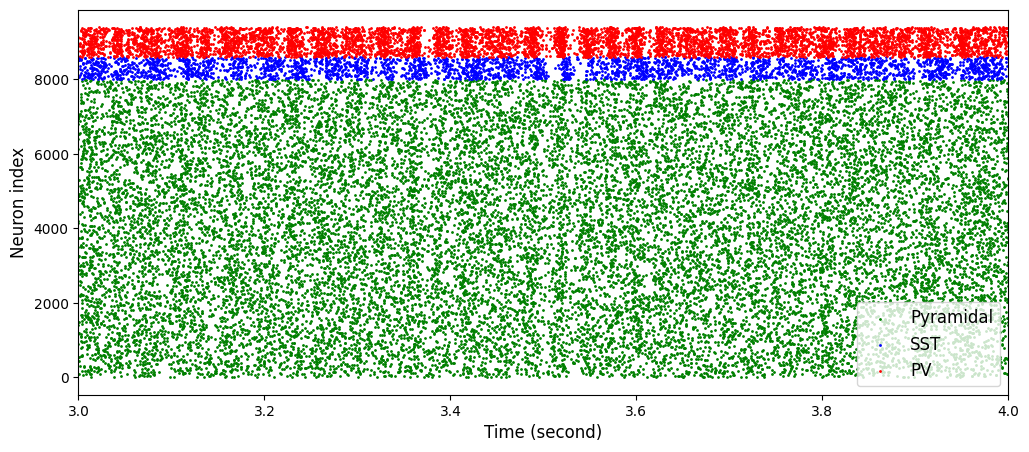

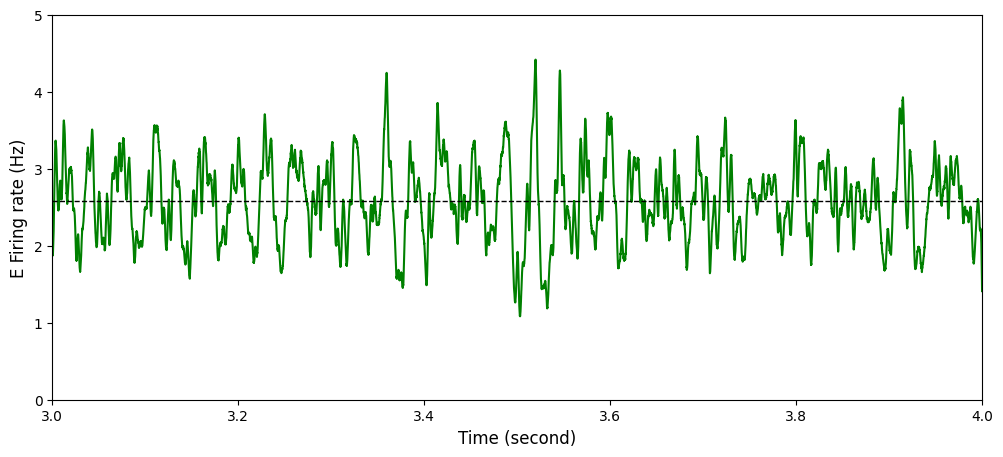

In [9]:
a1 = 3. ; a2 = 4
Fig=plt.figure(figsize=(12,5))

#plt.title('Raster Plot', fontsize=15)
#plt.scatter(spikemonI1.t[spikemonI1.i<1000]/second, spikemonI1.i[spikemonI1.i<1000] , color='red',s=2, label="FS")
plt.scatter(spikemonE1.t[spikemonE1.i<8000]/second, spikemonE1.i[spikemonE1.i<8000] + 0, color='green',s=1, label="Pyramidal")
plt.scatter(spikemonI2.t[spikemonI2.i<600]/second, spikemonI2.i[spikemonI2.i<600] + 8000, color='blue',s=1, label="SST")
plt.scatter(spikemonI1.t[spikemonI1.i<800]/second, spikemonI1.i[spikemonI1.i<800] +8600, color='red',s=1, label="PV")

plt.xlim(a1, a2)
plt.xlabel('Time (second)', fontsize=12)
plt.ylabel('Neuron index', fontsize=12)
plt.legend(fontsize=12)



Fig=plt.figure(figsize=(12,5))
plt.plot(ME1.t/second, ME1.smooth_rate(window='gaussian', width=1*ms)/Hz , c='green')
plt.axhline(mean(np.array(ME1.rate/Hz)[int((3/54)*540000):int((53/54)*540000)]),linestyle='--',linewidth=1, color='black')
plt.xlabel('Time (second)', fontsize=12)
plt.ylabel('E Firing rate (Hz)', fontsize=12)
plt.xlim(a1 , a2)
plt.ylim(0,5)





np.save("pop_t.npy", ME1.t/second)
np.save("pop_py.npy", ME1.smooth_rate(window='gaussian', width=1*ms)/Hz)


plt.show()

